<img src="../img/hu-logo.png" align="right" width="120">

# Decision trees

In this notebook we'll implement a decision tree algorithm.  The notebook will cover teh following steps:

1. Load a data set (`iris` data)
2. Build a reference solution using `sklearn`
3. Compare three metrics to quantify node impurity (entropy, gini, misclassification error)
4. Build a sample computation of the information gain (used to make splits in decision trees)
5. Build a decision tree class
6. Test the predict method
7. Build a small tree explorer app that allows us to see how hyperparameters affect tree construction

In [1]:
import math
import yaml
import graphviz

import numpy as np
import pandas as pd

import sklearn.tree
import sklearn.datasets
import sklearn.model_selection
import scipy.stats

import matplotlib.pyplot as plt
import IPython.display
import ipywidgets

In [2]:
plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "axes.grid": True,
    "axes.axisbelow": True,
})

## Load data

We'll use the `iris` data for testing our decision tree implementation.

In [3]:
iris = sklearn.datasets.load_iris()

In [4]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['y'] = iris.target

In [5]:
X = df[iris.feature_names].values
y = df["y"].values

In [6]:
X.shape

(150, 4)

In [7]:
len(y)

150

## Reference implementation in `sklearn`

### Defne tree parameters

- Impurity = Entropy
- Limit depth to 8 (tree will actually stop after 5 levels)

Check out the tree explorer at the end of the notebook to study the effects of hyperparameters on the resulting tree.

In [8]:
config_tree = {
    "criterion": "entropy",
    "max_depth": 8,
    "random_state": 501,
}

### Train decision tree

In [9]:
tree = sklearn.tree.DecisionTreeClassifier(
    **config_tree
)
tree = tree.fit(X, y)

### Visualize decision tree

Note the following observations:
- Tree f
- Pure nodes consisting of only one class
- Splitting reduces entropy
- Some erminal nodes contain very few samples -> consider early stopping to regularize tree

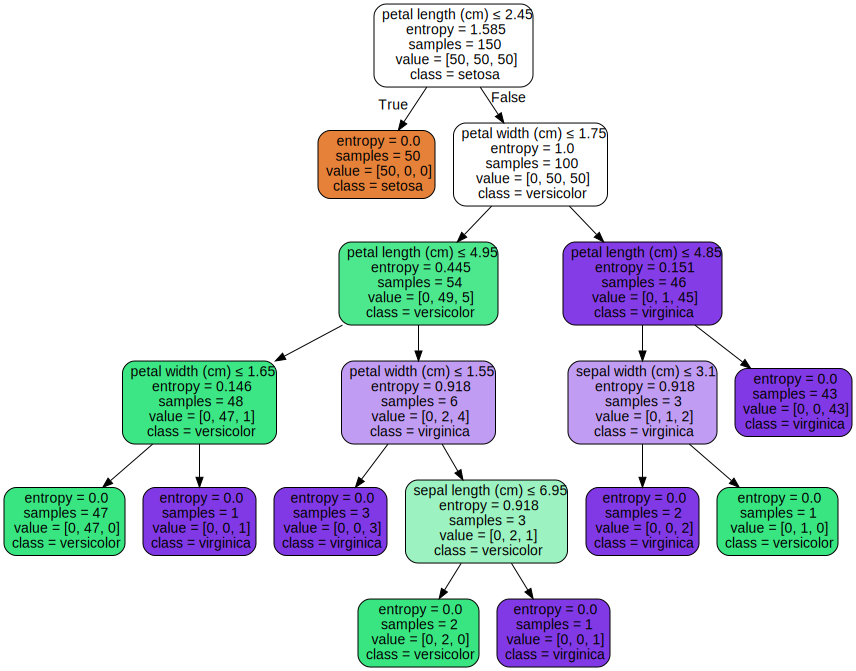

In [10]:
dot_data = sklearn.tree.export_graphviz(
    tree,
    out_file=None,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,
    rounded=True,
    special_characters=True
)
graphviz.Source(dot_data)

## Background

### Information gain ($IG$)

We'll split a node if information gain is larger than 0:

$
\quad {\displaystyle IG(\mathcal{D}_{parent}, \mathcal{D}_{left}, \mathcal{D}_{right}) = 
    H(\mathcal{D}_{parent}) - \frac{N_{left}}{N_{parent}} H(\mathcal{D}_{left}) - \frac{N_{right}}{N_{parent}} H(\mathcal{D}_{right})}
$

- $IG$: Information Gain
- $N_{parent}$: number of samples in the parent node
- $N_{left}$: number of samples in the left child node
- $N_{right}$: number of samples in the right child node
- $H$: Shannon entropy
- $\mathcal{D}_{parent}, \mathcal{D}_{left}, \mathcal{D}_{right}$: data sets (parent and child nodes)

### Shannon entropy $H$
Entropy $H$ is defined as 

$
\quad E = - \displaystyle\sum_i p_i \log_2 p_i
$

### Minimum Impurity Decrease 

- Decide when to stop splitting nodes (in addition to pure nodes)
- Node will be split of this split induces a decrease of the impurtiy greater (or equal) to MID
- MID functions as a threshold

$
{\displaystyle
\quad MID = \frac{N_{parent}}{N_{total}} \left[ H(\mathcal{D}_{parent}) - \frac{N_{left}}{N_{parent}} H(\mathcal{D}_{left}) - \frac{N_{right}}{N_{parent}} H(\mathcal{D}_{right}) \right]
}
$

### Impurity measures

#### Entropy

With proportion $p(j|t)$ of samples in class $j$ at node $t$:

$
\quad {\displaystyle H(t) = - \sum_{j=1}^k p(j|t) \log_2 p(j|t)}
$

Optimal entropy is 0 when all samples at a node belong to the same class

In [11]:
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

#### Gini Index

$
\quad {\displaystyle G(t) = 1 - \sum_{j=1}^k \big(p(j|t)\big)^2}
$

Minimized when all samples at a node belong to the same class. Maximal value for $p(j|t) = \frac 1 k$.

In [12]:
def gini(p):
    return 1-np.power(p, 2) - np.power((1-p), 2)

#### Misclassification error

$
\quad {\displaystyle MC(t) = 1 - \max_k p(j|t)}
$

In [13]:
def error(p):
    return 1 - np.max([p, 1-p], axis=0)

#### Comparison

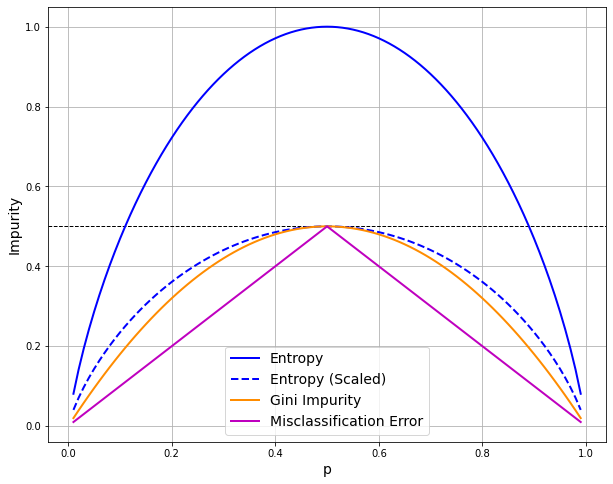

In [14]:
x = np.arange(0.01, 1.0, 0.01)

plt.plot(x, entropy(x), linewidth=2, label="Entropy", c="b")
plt.plot(x, entropy(x)/2, linewidth=2, label="Entropy (Scaled)", c="b", linestyle="--")
plt.plot(x, gini(x), linewidth=2, label="Gini Impurity", c="darkorange")
plt.plot(x, error(x), linewidth=2, label='Misclassification Error', c="m")

plt.legend(
    loc="lower center",
    ncol=1,
    fontsize=14,
)

plt.axhline(y=0.5, linestyle="--", c='k', zorder=1, linewidth=1)
plt.xlabel("p", fontsize=14)
plt.ylabel("Impurity", fontsize=14)
plt.show()

## Some first steps for building our own tree

In [15]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### Let's look at a single feature

In [16]:
values = X[:,2]
unique_values = np.sort(np.unique(values))

#### All possible cutoff values

In [17]:
cutoffs = (unique_values[:-1] + unique_values[1:])/2

In [18]:
for i, cutoff in enumerate(cutoffs):
    i, cutoff

In [19]:
i = 8
cutoff = cutoffs[i]
cutoff

2.45

#### Implement split based on feature

In [20]:
yhat = X[:,2]<=cutoff

In [21]:
yhat

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

#### Entropy: Parent node

In [22]:
def compute_entropy(y):
    # number of samples
    n = len(y)
    # unique classes in `y_class`
    classes = set(y)

    # compute number of observations in each class
    n_c = np.zeros(len(classes))
    # compute probability for a sample to be in class
    p_c = np.zeros(len(classes))
    # compute entropy for each class
    e_c = np.zeros(len(classes))

    # computation
    for i, c in enumerate(classes):
        n_c[i] = np.sum(y==c)
        p_c[i] = (n_c[i]/n)
        e_c[i] = -p_c[i]*np.log2(p_c[i])
    assert n == sum(n_c)

    # total entropy
    e_p = np.sum(e_c)
    
    # return
    return e_p, n

In [23]:
e_p, n_p = compute_entropy(y)
e_p, n_p

(1.584962500721156, 150)

#### Entropy: Left child node

In [24]:
yhat

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [25]:
y[yhat]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [26]:
e_cl, n_cl = compute_entropy(y[yhat])
e_cl, n_cl

(0.0, 50)

#### Entropy: Right child node

In [27]:
e_cr, n_cr = compute_entropy(y[~yhat])
e_cr, n_cr

(1.0, 100)

#### Derive information gain

In [28]:
e_p - (n_cl/n_p * e_cl + n_cr/n_p * e_cr)

0.9182958340544894

## Manual implementation: Our decision tree class

In [29]:
class DecisionTree():

    def __init__(self, feature_names, class_names, class_values, max_depth=5, eps=1e-8, verbose=0):
        self.feature_names = feature_names
        self.class_names = class_names
        self.class_values = class_values

        self.max_depth = max_depth
        self.eps = eps # break ties in information gain
        self.verbose = verbose


    def fit(self, X, y, depth, seeds):
        """
        Tree builder. This is a recursive function. Break for pure nodes or when max tree depth is reached.
        """

        # all `y` belong to the same class (pure node) -> terminate
        if len(np.unique(y)) == 1:
            return self._final_node(y)

        # reached `max_depth` -> terminate
        elif depth >= self.max_depth:
            return self._final_node(y)

        # add splits
        else:

            if depth<len(seeds):
                np.random.seed(seeds[depth])

            # find one split given an information gain 
            column_chosen, cutoff_chosen, split_chosen, ig_chosen = self._find_split(X, y)
            node = {
                "entropy": float(round(self._entropy(y), 4)),
                "column": int(column_chosen),
                "cutoff": float(np.round(cutoff_chosen, 4)),
                "table": self._table(y),
                "split": f"{self.feature_names[column_chosen]} <= {cutoff_chosen:.4f}",
            }
            # generate new child trees
            node["-left"] = self.fit(
                X[split_chosen, :], y[split_chosen], depth+1, seeds
            )
            node["-right"] = self.fit(
                X[~split_chosen, :], y[~split_chosen], depth+1, seeds
            )

            self.fitted_tree = node

        return node


    def predict(self, X):
        """
        Walk through tree for new data samples.
        """
        predictions = np.zeros(len(X), dtype=np.int)
        for i, xi in enumerate(X):  # for each row in test data 
            node = self.fitted_tree
            while node.get("cutoff"):
                if xi[node["column"]] <= node["cutoff"]:
                    node = node["-left"]
                else:
                    node = node["-right"]
            else:
                predictions[i] = node.get("value")
        return predictions


    def _find_split(self, X, y):
        """
        Determine whether to split a parent node and which feature/cutoff to use.
        """
        scores = []
        
        # loop over features
        for c in range(X.shape[1]):

            values = X[:, c]

            # loop over possible cutoffs
            unique_values = np.sort(np.unique(values))
            cutoffs = (unique_values[:-1] + unique_values[1:])/2
            for i, cutoff in enumerate(cutoffs):
                # split
                yhat = yhat = X[:, c]<=cutoff

                # entropy calculation
                entropy_parent = self._entropy(y)
                entropy_child_left = self._entropy(y[yhat])
                entropy_child_right = self._entropy(y[~yhat])

                # information gain
                information_gain = (
                    entropy_parent
                    - np.mean(yhat) * entropy_child_left
                    - np.mean(~yhat) * entropy_child_right
                )

                # save and log
                scores.append([c, cutoff, len(yhat), sum(yhat), sum(~yhat), information_gain, entropy_parent])
                self._log(f"col={c} | cutoff={cutoff:.2f} | gain={information_gain:.8f} | ent={entropy_parent:.4f}")

        scores = pd.DataFrame(
            scores,
            columns=["column", "cutoff", "np", "ncl", "ncr", "ig", "ep"]
        )
        # break ties
        scores["ig"] += np.random.uniform(-self.eps, self.eps, scores.shape[0])
        #
        scores = scores.sort_values("ig", ascending=False)

        column_chosen = scores["column"].values[0]
        cutoff_chosen = scores["cutoff"].values[0]
        split_chosen = X[:, column_chosen] <= cutoff_chosen
        ig_chosen = scores["ig"].values[0]
        ig_all = scores["ig"].values
        return column_chosen, cutoff_chosen, split_chosen, ig_chosen#, ig_all


    def _final_node(self, y):
        return {
            "entropy": float(round(self._entropy(y), 4)),
            "table": self._table(y),
            "value": self._mode(y),
        }


    def _table(self, y):
        return " | ".join(
            [
                f"{yi}: {np.sum(y==yi)}"
                for yi
                in self.class_values
            ]
        )


    def _log(self, x):
        if self.verbose>0:
            print(x)


    @staticmethod
    def _entropy(y):
        """
        Entropy calculation.
        """
        n = len(y)
        classes = set(y)
        n_c = np.zeros(len(classes))
        p_c = np.zeros(len(classes))
        e_c = np.zeros(len(classes))
        for i, c in enumerate(classes):
            n_c[i] = np.sum(y==c)
            p_c[i] = (n_c[i]/n)
            e_c[i] = -p_c[i]*np.log2(p_c[i])
        return np.sum(e_c)


    @staticmethod
    def _mode(x):
        """
        Majority vote with tie breaker.
        """
        values, counts = np.unique(x, return_counts=True)
        return int(np.random.choice(values[counts == np.max(counts)]))

### Fit

In [30]:
decision_tree = DecisionTree(
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    class_values=set(y)
)
assert set(y) == set(range(len(iris.target_names)))

X = df[iris.feature_names].values
y = df["y"].values

res = decision_tree.fit(X, y, 0, seeds=[19])

### Inspect results

In [31]:
print(yaml.dump(decision_tree.fitted_tree, indent=4, sort_keys=False))

entropy: 1.585
column: 2
cutoff: 2.45
table: '0: 50 | 1: 50 | 2: 50'
split: petal length (cm) <= 2.4500
-left:
    entropy: 0.0
    table: '0: 50 | 1: 0 | 2: 0'
    value: 0
-right:
    entropy: 1.0
    column: 3
    cutoff: 1.75
    table: '0: 0 | 1: 50 | 2: 50'
    split: petal width (cm) <= 1.7500
    -left:
        entropy: 0.4451
        column: 2
        cutoff: 4.95
        table: '0: 0 | 1: 49 | 2: 5'
        split: petal length (cm) <= 4.9500
        -left:
            entropy: 0.1461
            column: 3
            cutoff: 1.65
            table: '0: 0 | 1: 47 | 2: 1'
            split: petal width (cm) <= 1.6500
            -left:
                entropy: 0.0
                table: '0: 0 | 1: 47 | 2: 0'
                value: 1
            -right:
                entropy: 0.0
                table: '0: 0 | 1: 0 | 2: 1'
                value: 2
        -right:
            entropy: 0.9183
            column: 3
            cutoff: 1.55
            table: '0: 0 | 1: 2 | 2: 4'


### Make predictions

In [32]:
decision_tree.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Tree explorer

Ensure that you have `ipywidgets` (and notebook/lab) extension installed:

    pip install ipywidgets
    jupyter nbextension enable --py widgetsnbextension
    jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [33]:
def plot_tree(**kwargs):
    
    decision_tree = sklearn.tree.DecisionTreeClassifier(
        random_state=501,
        **kwargs
    ).fit(X, y)

    graph = graphviz.Source(
        sklearn.tree.export_graphviz(
            decision_tree,
            out_file=None,
            feature_names=iris.feature_names,  
            class_names=iris.target_names,  
            rounded=True,
            filled=True,
        )
    )
    IPython.display.display(
        IPython.display.SVG(
            graph.pipe(format='svg')
        )
    )

    return decision_tree

In [34]:
IPython.display.display(
    ipywidgets.interactive(
        plot_tree,
        criterion=["gini", "entropy"],
        max_depth=[2,3,4],
        max_features=(1,4),
        min_samples_split=(2,10),
        min_impurity_decrease=(0.0,1.0),
        min_samples_leaf=(2,20),
        max_leaf_nodes=(2, 20),
    )
)

interactive(children=(Dropdown(description='criterion', options=('gini', 'entropy'), value='gini'), Dropdown(d…

&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 5 <br>
2020 <br>